### Klasyfikacja całych słów
Zagdnieniem jakie poruszymy w tym rodziale jest rozpoznawanie całych słów zapisanych pismem odręcznym. 

Rozpoczynam od załadowania niezbędnych bibliotek. Będziemy używać biblioteki "Mxnet" oraz "GluonNLP" do trenowania sieci neuronowej, która posłuży do rozpoznawania pisma odręcznego. Dane testowe pochodzą ze zbioru odręcznie zapisanych formularzy iam.

Do przygotowania zbioru danych użyjemy biblioteki pochodzącej ze zbioru AWS o nazwie OCR. Dzięki tej bibliotece możemy wczytać zbiór i przygotować go do przetwarzania. Ważne jest aby w pliku credentials.json określić dane dostępowe do api serwisu iam.

In [1]:
### Import  bibliotek

import random

random.seed(123)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import gluonnlp as nlp
import numpy as np
import cv2 as cv
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS

from ocr.utils.denoiser_utils import SequenceGenerator

from ocr.utils.beam_search import ctcBeamSearch

from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

[07:20:20] ../src/c_api/../operator/custom/custom-inl.h:57: New registration is overriding existing custom operator _smoothing_with_dim


In [2]:
ctx = mx.gpu(0)

#### Przygotowanie zbioru danych.
Badanie przeprowadzimy na czterech przygotowanych przeze mnie formularz. Jeden z formularzy został zapisany w języku polskim. Pozostałe formularze zostały zapisane w języku angielskim.

In [3]:
import json
 
files = [
    'A00-000',
    'A00-002',
    'A00-003',
    'A00-001'
]

words = json.load(open('my-dataset/words.json',))

test_ds = []

for x in files:
    img = cv.imread(f'my-dataset/{x}.png')[:, :, 0]
    img = np.array(img)
    text = np.array(words[x])
    test_ds.append([img, text])

In [4]:
random.seed(1)

In [5]:
figs_to_plot = 4
images = []

n = 0
for i in range(0, figs_to_plot):
    image, _ = test_ds[i]
    images.append(image)

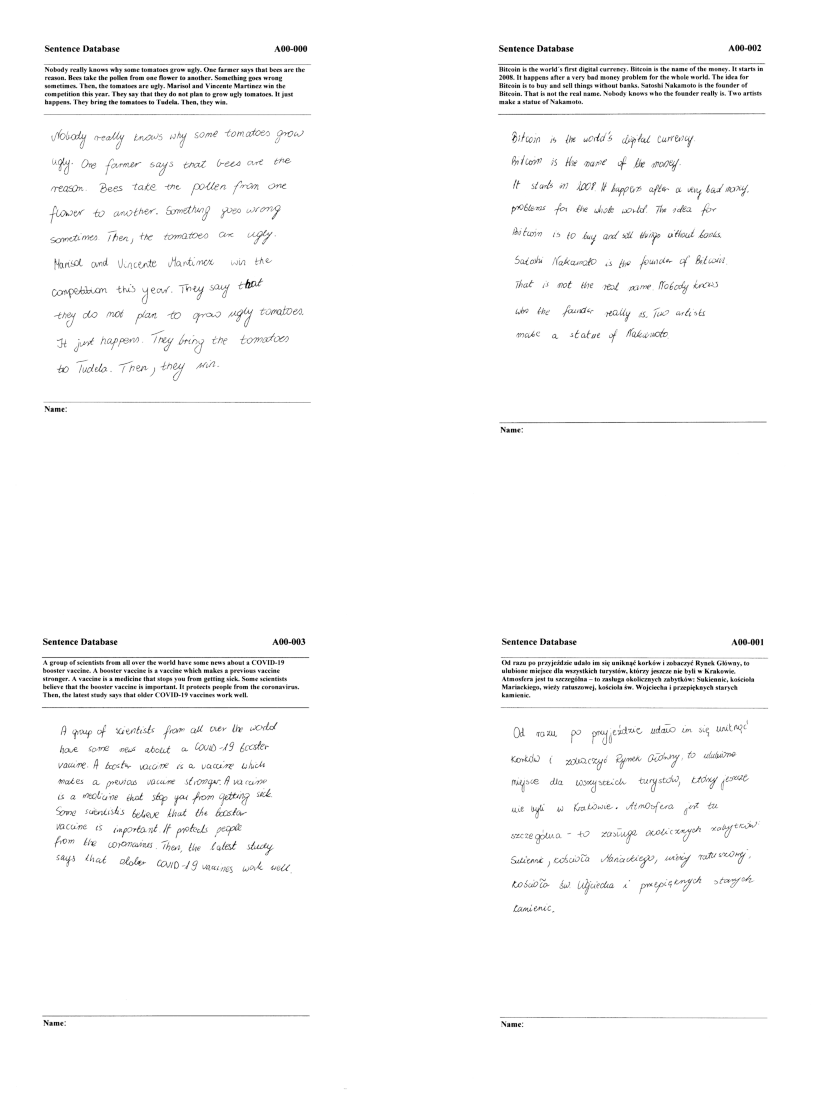

In [6]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

#### Segmentacja akapitów

Na załadowanym obrazie należy przewidzieć obszar w którym występuje tekst pisany odręcznie. Model został przeszkolony przy użyciu algorytmu omówionego w notatniku segmentacja akapitów.

In [7]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [8]:
paragraph_segmentation_net.hybridize()

[07:20:40] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


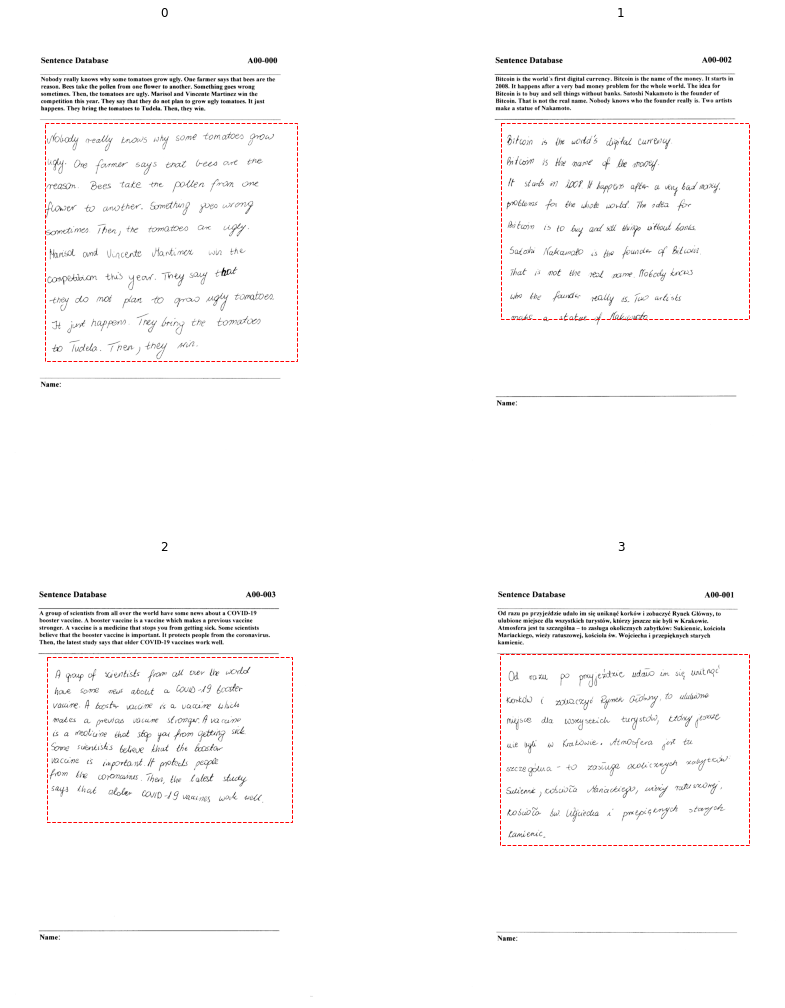

In [9]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

#### Przygotowanie zdjęć

Wycinamy z obrazu tylko ramkę z ręcznie pisanym tekstem i dostarczamy ją dalej do algorytmu.

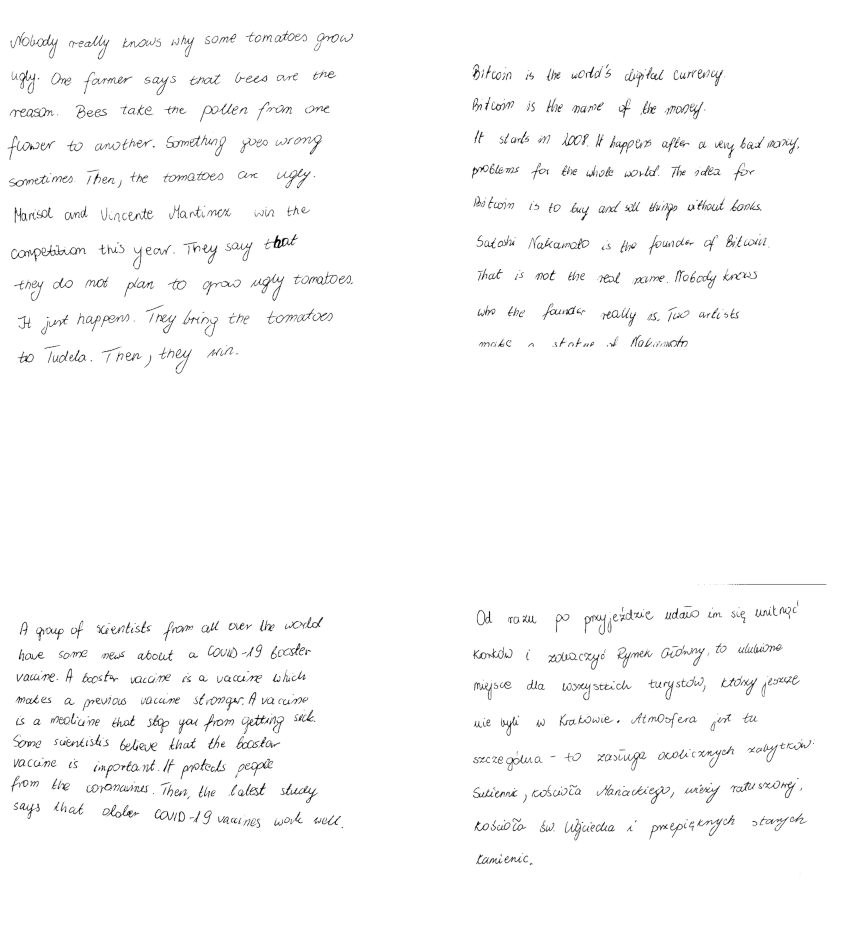

In [10]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

#### Segmentacja lini tesktu i słów

Mając formularz zawierający wyłącznie tekst pisany odręcznie, należy przewidzieć ramkę dla każdego słowa. Sposób działania modelu został przedstawiony w notatniku segmentacja tekstu i słów.

In [11]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

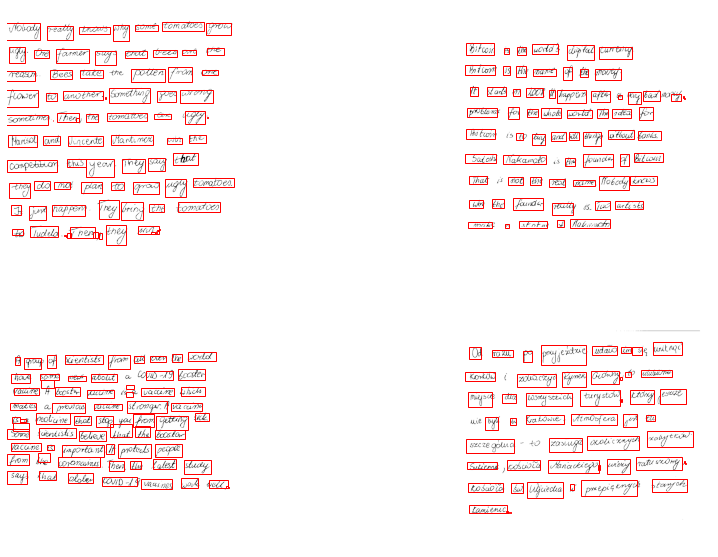

In [12]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

#### Dopasowanie pojedyńczych słów do lini

Następnie musimy z tekstu wydobyć całe lini posiadające tekst odreczny.

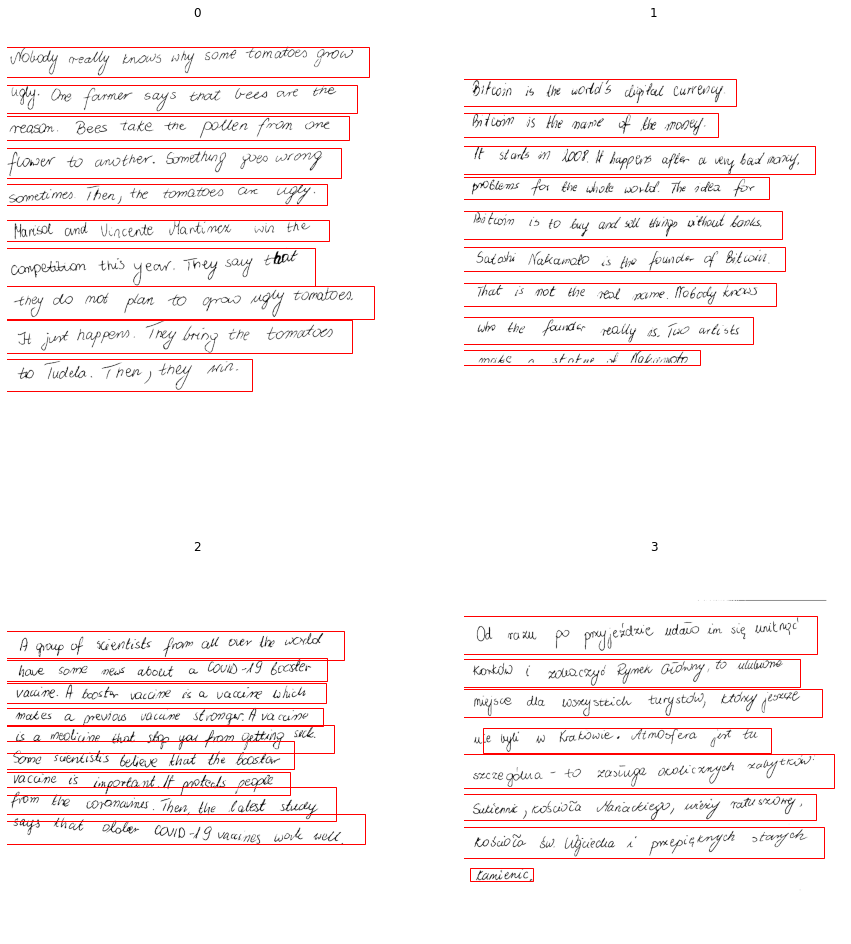

In [13]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

#### Rozpoznawanie pisma
Biorąc pod uwagę każdy wiersz tekstu, przewidujemy ciąg tekstu pisanego odręcznie. Działanie tej sieci został przedstawione w notatniku rozpoznawanie pisma.

In [14]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [15]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

#### Prawdopodobieństwo znaków w tekście

In [16]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [17]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

#### Odszumianie tekstu wyjściowego

Używamy denoisera seq2seq, aby przetłumaczyć zaszumione wejście na lepsze jakościowo wyjście.

In [18]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [19]:
denoiser.hybridize(static_alloc=True)

In [20]:
ctx_nlp = mx.gpu(0)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

In [21]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [22]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [23]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()

In [24]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence))

This sentnce has an eror
Choice
T h i s   s e n t e n c e 


#### Wyniki jakościowe

- [AM] Arg Max CTC Decoding
- [BS] Beam Search CTC Decoding
- [D] Adding Text Denoiser

[AM] vlobody ceally knows why some tomatoes grow
[D ] s o m e b o d y   r e a l l y   k n o w s   w
[AM] ngly. Ohe fammer says that bees ane the
[D ] u g l y .   T h e   f a r m e r   s a y s
[AM] reasam. Bees take the pollen from come
[D ] r e a s o n .   B e e s   t a k e   t h
[AM] flomser to another. Something gues wrong
[D ] f l o w e r   t o   a n o t h e r .   S o
[AM] sometimes. Thery the tomatoes are ugly.
[D ] s o m e t i m e s .   T h e r e b y   t h
[AM] Marieal and Vincente Mantimere win the
[D ] M a r i e l   a n d   V i n c e n t e
[AM] competitian this yeorr. They sany that
[D ] c o m p e t i t i o n   t h i s   y e a
[AM] they do not plan to grous mgly tomatoes.
[D ] t h e y   d o   n o t   p l a n   t o   g
[AM] It just happens. They bring the tomatues
[D ] I t   j u s t   h a p p e n s .   T h e y
[AM] to Tudela. Ther; they sin-
[D ] t o   J u d e a .   T h e n
[AM] Bitcain is the workd's digital currewcs.
[D ] B r i t a i n   i s   t h e   w o r l d '
[AM] Britcin i

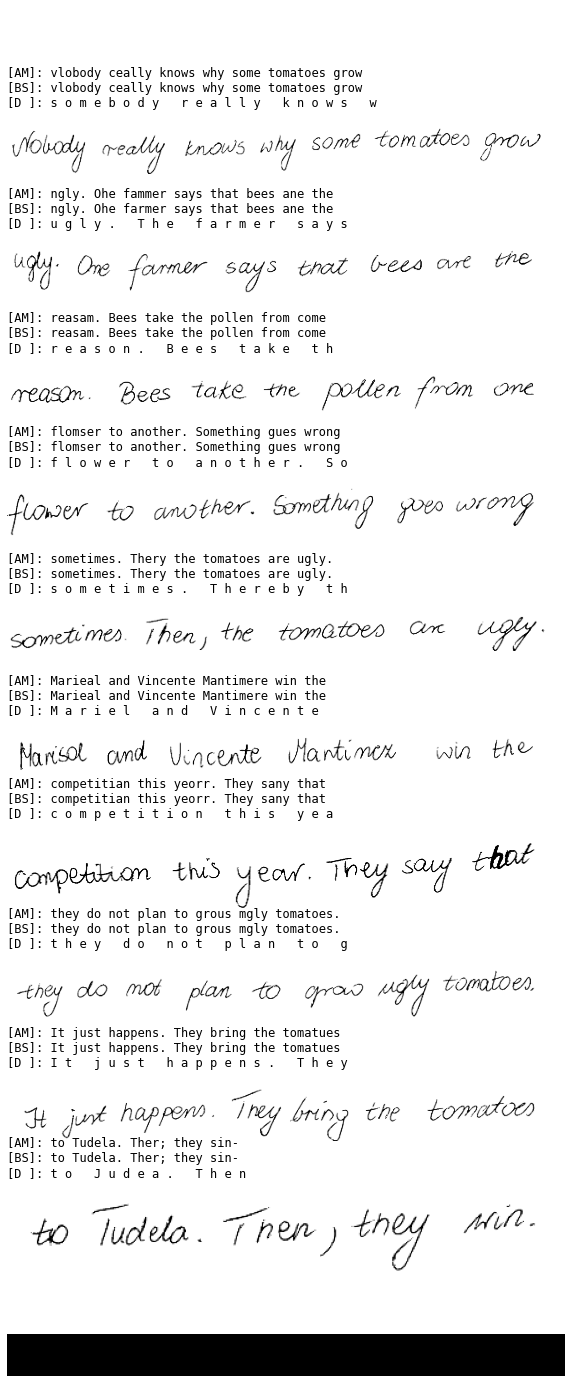

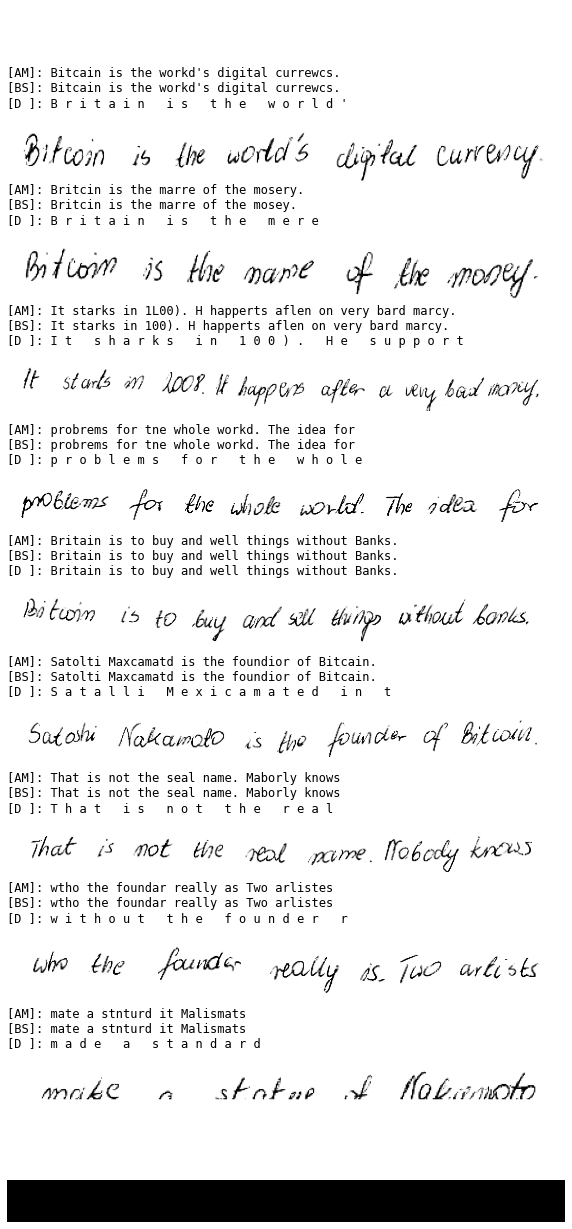

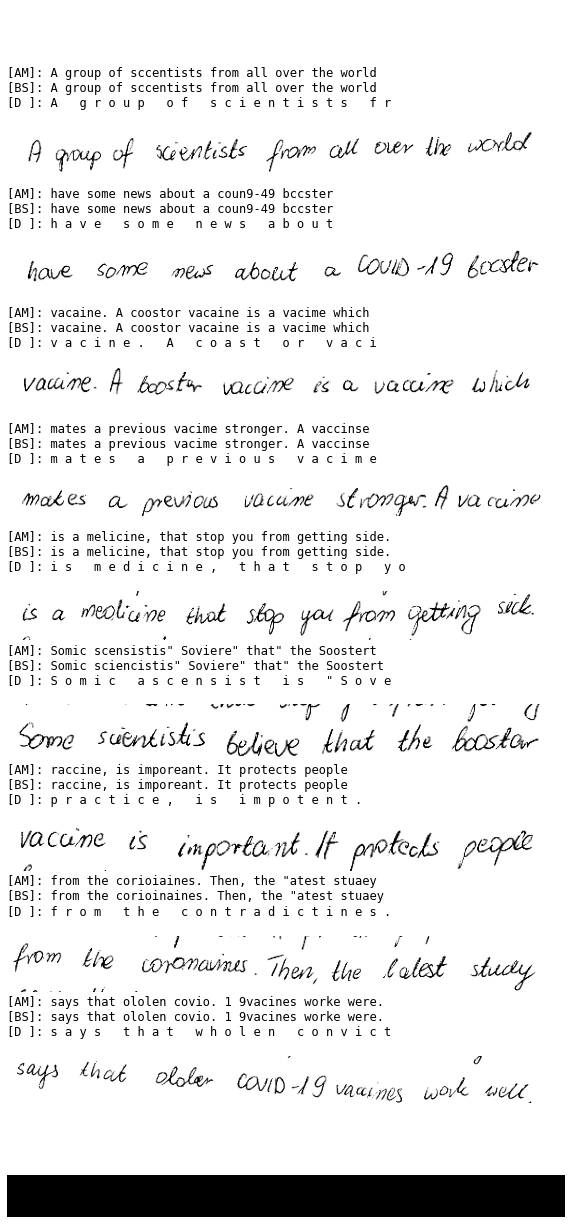

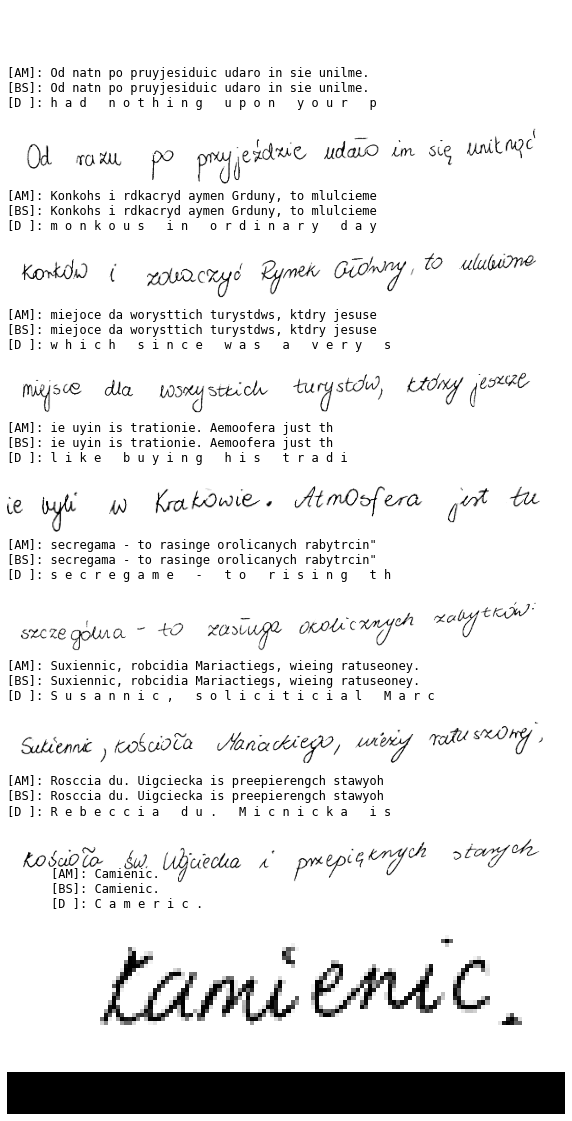

In [25]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("\n\n\n\n[AM]: {}\n[BS]: {}\n[D ]: {}\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

#### Wyniki ilościowe

Iterujemy przez zbiór testowy, aby otrzymać wskażnik błędu znaku (ang. Character Error Rate, CER).

In [26]:
sclite = ScliteHelper('../SCTK/bin')

def get_qualitative_results_lines(denoise_func):
    sclite.clear()
    test_ds_line = IAMDataset("line", train=False)
    for i in tqdm(range(1, len(test_ds_line))):
        image, text = test_ds_line[i]
        line_image = exposure.adjust_gamma(image, 1)
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        decoded_text = denoise_func(character_probabilities)
        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        sclite.add_text([decoded_text], [actual_text])
    
    cer, er = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

In [27]:
def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(1, len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=form_size)
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_bb = paragraph_bb[0].asnumpy()
        paragraph_bb = expand_bounding_box(paragraph_bb, expand_bb_scale_x=0.01,
                                               expand_bb_scale_y=0.01)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb, image_size=segmented_paragraph_size)
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = exposure.adjust_gamma(line_image, 1)
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    cer, _ = sclite.get_cer()
    print("Mean CER = {}".format(cer))
    return cer

CER z liniami wstępnie segmentowanymi

In [28]:
get_qualitative_results_lines(get_arg_max)

100%|█████████████████████████████████████████████████| 1859/1859 [01:24<00:00, 22.12it/s]


Mean CER = 8.4


8.4

In [29]:
get_qualitative_results_lines(get_denoised)

100%|█████████████████████████████████████████████████| 1859/1859 [13:18<00:00,  2.33it/s]


Mean CER = 38.3


38.3

In [30]:
get_qualitative_results(get_arg_max)

100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]

Mean CER = 45.4


45.4

In [31]:
get_qualitative_results(get_beam_search)

100%|███████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.70s/it]

Mean CER = 45.3


45.3

In [32]:
get_qualitative_results(get_denoised)

100%|███████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.70s/it]

Mean CER = 65.4


65.4

#### Podsumowanie

Algorytm poradził sobię dobrze z tekstem zapisanym w języku angielskim. Przewidziany tekst zawierał drobne błędy, jednak w wikszości słowa pokrywają się z słowami pierwotnie zapisanymi.

W przypadku języku polskiego, niestety algorytm nie dał sobie rady. Ze względu na to że był szkolony na języku angileskim, nie udało się rozpoznać słów zapisanych w języku polskim.